In [1]:
import sys
sys.path.insert(0, '../')

# module imports
import pandas as pd
import numpy
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from collections import Counter
from itertools import chain
import ast
import random
from datetime import datetime
from importlib import reload

# local imports
from fit_model import fit
import test_model
import BERT
import build_dataset
import baseline
import fit_model

# reload modules
reload(BERT)
reload(build_dataset)
reload(baseline)
reload(fit_model)
reload(test_model)


# For reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
variant = "bert_0"

In [3]:
use_fusion_embeddings = False

In [4]:
model = torch.load(f"../saved_models/{variant}.pt")

In [5]:
# load data from csv
DATASET_PATH = "../../data/final_data_200.csv"
df = pd.read_csv(DATASET_PATH)

In [6]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm import tqdm

BATCH_SIZE = 8 
num_workers = 4

# Function for setting seed (assuming it's defined)
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# split data into train, val, test
train_df, _, test_df = build_dataset.stratified_user_week_split(df, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, ensure_user_in_all_sets=True)

# compute ranks for each user based on the train set
rank_dict = build_dataset.compute_rank_dict(train_df)

# create vocabulary based on the whole dataset
dataset = build_dataset.BertMobilityDataset(df,rank_dict, user_embedding=False)
vocab = dataset.vocab 

# Initialize the datasets with the rank dictionary and vocabulary
test_dataset = build_dataset.BertMobilityDataset(test_df, rank_dict, vocab)

# Create the DataLoaders
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, worker_init_fn=seed_worker, num_workers=num_workers, drop_last=True)

ntokens_location = len(vocab)

In [7]:
measures_test = test_model.test_loop(model, test_loader, ntokens_location, iterations = 10, use_fusion_embeddings = use_fusion_embeddings)
avg_test_loss, masked_tokens, accuracy, y_expected, y_predicted, random_mask, true_labels_list, predicted_labels_list,accuracy_list = measures_test

# create dictionary for the results
results = {
    "variant": variant,
    "avg_test_loss": avg_test_loss,
    "masked_tokens": masked_tokens,
    "accuracy": accuracy,
    "y_expected": y_expected,
    "y_predicted": y_predicted,
    "random_mask": random_mask,
    "true_labels_list": true_labels_list,
    "predicted_labels_list": predicted_labels_list,
    "accuracy_list": accuracy_list
}

# save measures list as pickle
import pickle
with open(f"../../output/{variant}_measures_test.pkl", "wb") as f:
    pickle.dump(results, f)

Test Loss: 3.5179, Test Accuracy: 0.3827


In [8]:
top_k_measures_test = test_model.test_loop_topk(model, test_loader, ntokens_location, iterations = 10, use_fusion_embeddings = use_fusion_embeddings)
avg_test_loss, accuracy_top1, accuracy_top5, accuracy_top10 = top_k_measures_test
# create dictionary for the results
results_topk = {
    "variant": variant,
    "avg_test_loss": avg_test_loss,
    "accuracy_top1": accuracy_top1,
    "accuracy_top5": accuracy_top5,
    "accuracy_top10": accuracy_top10
}
# save measures list as json 
import json
with open(f"../../output/{variant}_measures_test_topk.json", "w") as f:
    json.dump(results_topk, f)

Test Loss: 3.5305, Top-1 Accuracy: 0.3793, Top-5 Accuracy: 0.6523, Top-10 Accuracy: 0.7437


In [9]:
# read measures test topk json
variant = "bert_0_500"
with open(f"../../output/{variant}_measures_test_topk.json", "r") as f:
    data = json.load(f)
    # print measures formattet
    print(data["variant"])
    print(f"avg_test_loss: {data['avg_test_loss']:.4f}")
    print(f"accuracy_top1: {data['accuracy_top1']:.4f}")
    print(f"accuracy_top5: {data['accuracy_top5']:.4f}")
    print(f"accuracy_top10: {data['accuracy_top10']:.4f}")

bert_0_500
avg_test_loss: 4.4183
accuracy_top1: 0.3241
accuracy_top5: 0.5728
accuracy_top10: 0.6658


### comparison true labels with predicted labels

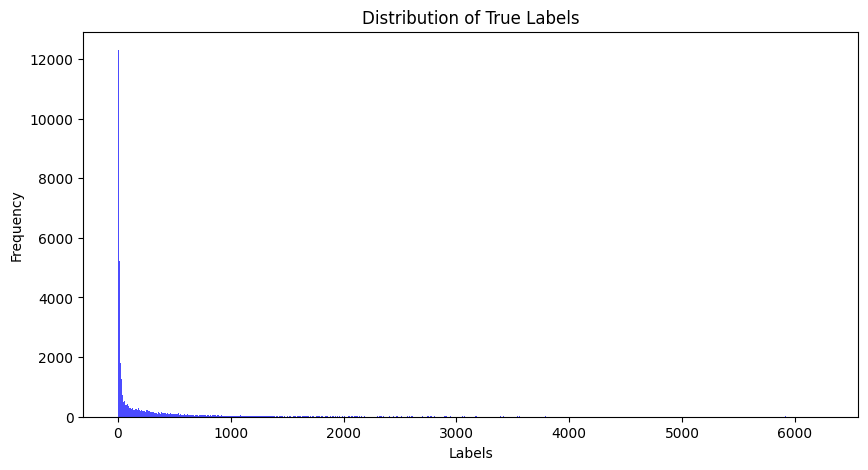

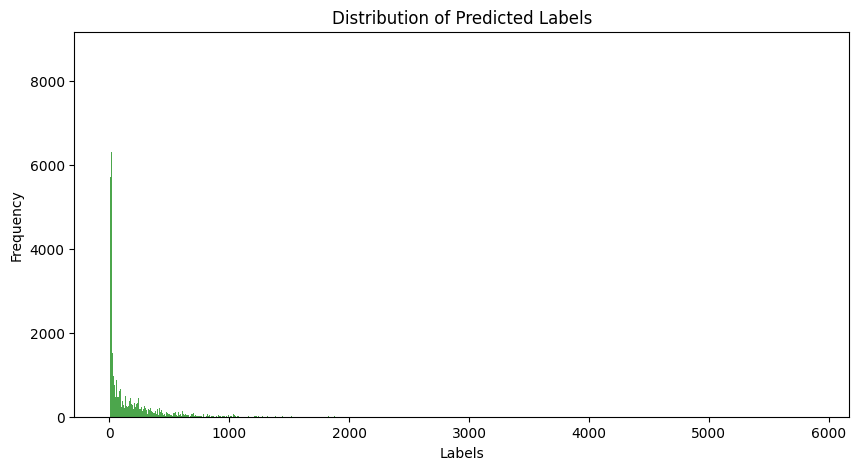

In [10]:
import matplotlib.pyplot as plt

# Plot for True Labels
plt.figure(figsize=(10, 5))
plt.hist(true_labels_list, bins=1000, alpha=0.7, color='blue')
plt.title('Distribution of True Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

# Plot for Predicted Labels
plt.figure(figsize=(10, 5))
plt.hist(predicted_labels_list, bins=1000, alpha=0.7, color='green')
plt.title('Distribution of Predicted Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


In [11]:
# set up bins for the heatmap
lat_bins = np.linspace(55.52217281782121, 55.88796262687908, 200)
lon_bins = np.linspace(11.987848798727102, 12.734717261629013, 200)

In [12]:
def decode_positions(indices, vocab):
    return [vocab[i] for i in indices]
# Convert bin numbers to center points of the bins
def get_center_points(coord_tuples, single=False):
    center_points = []
    lat = []
    lon = []
    for lat_bin, lon_bin in coord_tuples:
        lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
        lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
        lat.append(lat_center)
        lon.append(lon_center)
        center_points.append((lat_center, lon_center))
    if single:
        return lat, lon
    else:
        return center_points

In [13]:
from collections import defaultdict

correct_predictions_counter = defaultdict(int)
total_occurrences_counter = defaultdict(int)

for true_label, predicted_label in zip(true_labels_list, predicted_labels_list):
    total_occurrences_counter[true_label] += 1
    if true_label == predicted_label:
        correct_predictions_counter[true_label] += 1

# Calculate the ratio of correct predictions for each label
accuracy_ratio_per_label = {
    label: correct_predictions_counter[label] / total_occurrences_counter[label]
    for label in total_occurrences_counter
}
# Assuming decode_positions function extracts the coordinates for the labels and get_center_points calculates the center points
top_labels_string = decode_positions(total_occurrences_counter.keys(), vocab)
top_labels_tuples = [eval(coord) for coord in top_labels_string]
lat,lon = get_center_points(top_labels_tuples,single=True)

# Create a DataFrame from the collected data
labels_data = {
    'label': list(total_occurrences_counter.keys()),
    'accuracy_ratio': [accuracy_ratio_per_label[label] for label in total_occurrences_counter],
    'correct_predictions': [correct_predictions_counter[label] for label in total_occurrences_counter],
    'total_occurrences': [total_occurrences_counter[label] for label in total_occurrences_counter],
    'lat': lat,
    'lon': lon
}
labels_df = pd.DataFrame(labels_data)

In [14]:
# decode label into pos in labels_df
labels_df['pos'] = decode_positions(labels_df['label'], vocab)
# groupby df by pos and count number of unique users and name column "no unique users"
pos_counts = df.groupby('pos').user.nunique().reset_index(name='no_unique_users')
# convert pos to string
pos_counts['pos'] = pos_counts['pos'].apply(str)
# merge pos_counts with labels_df on pos

labels_df = labels_df.merge(pos_counts, left_on='pos', right_on='pos', how='left')

In [15]:
# Filter labels with 'Total Occurrences' greater than 5
labels_info = labels_df[labels_df['total_occurrences'] > 5]

# Assuming decode_positions function extracts the coordinates for the labels and get_center_points calculates the center points
top_labels_string = decode_positions(labels_info['label'].tolist(), vocab)
top_labels_tuples = [eval(coord) for coord in top_labels_string]

# Adjusting to get center points
top_labels_center_points = get_center_points(top_labels_tuples)

/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_41934/3919538085.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.2%}'.for

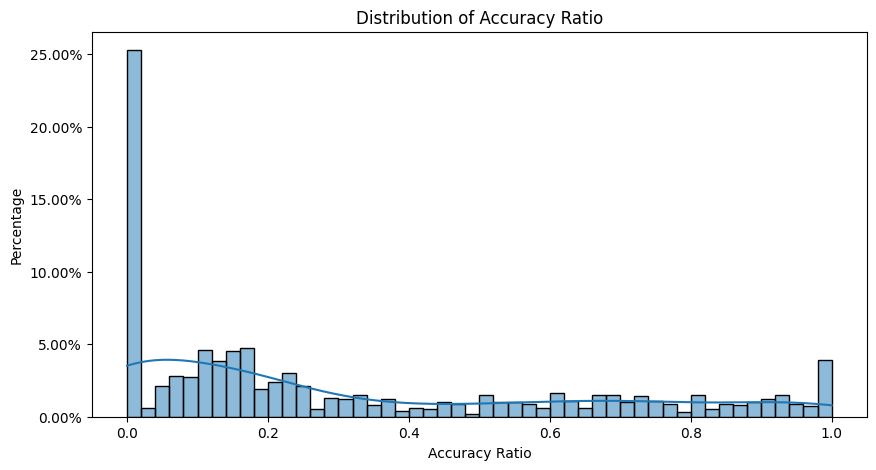

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate weights for each observation
weights = [1.0 / len(labels_info)] * len(labels_info)

# Plotting with seaborn
plt.figure(figsize=(10, 5))
sns.histplot(labels_info, x="accuracy_ratio", bins=50, weights=weights, stat="probability", kde=True)
plt.ylabel('Percentage')
plt.xlabel('Accuracy')
plt.title('Distribution of Accuracy per Location')

# Convert y-axis labels to percentage
y_vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.2%}'.format(x) for x in y_vals])

plt.show()


/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/s212588/.conda/envs/locpredict/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


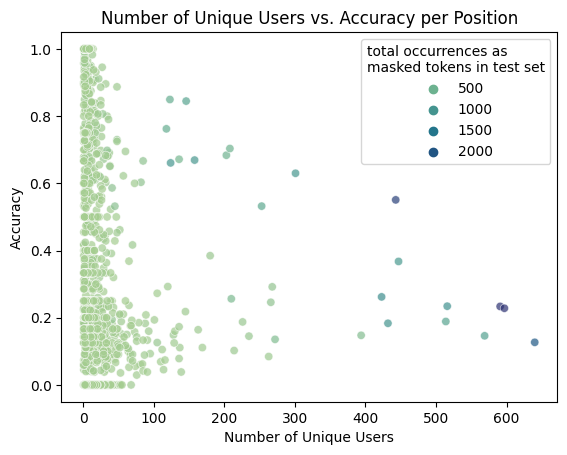

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming labels_df is your DataFrame and is already defined

# Create a scatter plot with varying marker sizes to represent 'total_occurrences'
sns.scatterplot(data=labels_df, x='no_unique_users', y='accuracy_ratio', hue='total_occurrences', palette="crest", alpha=0.7)

# Adding title and labels for clarity
plt.title('Number of Unique Users vs. Accuracy per Position')
plt.xlabel('Number of Unique Users')
plt.ylabel('Accuracy')

# Change the legend title
plt.legend(title='total occurrences as \nmasked tokens in test set')

# save the plot
plt.savefig("../../figures/unique_users_vs_accuracy_ratio.png", dpi = 300)

# Show the plot
plt.show()


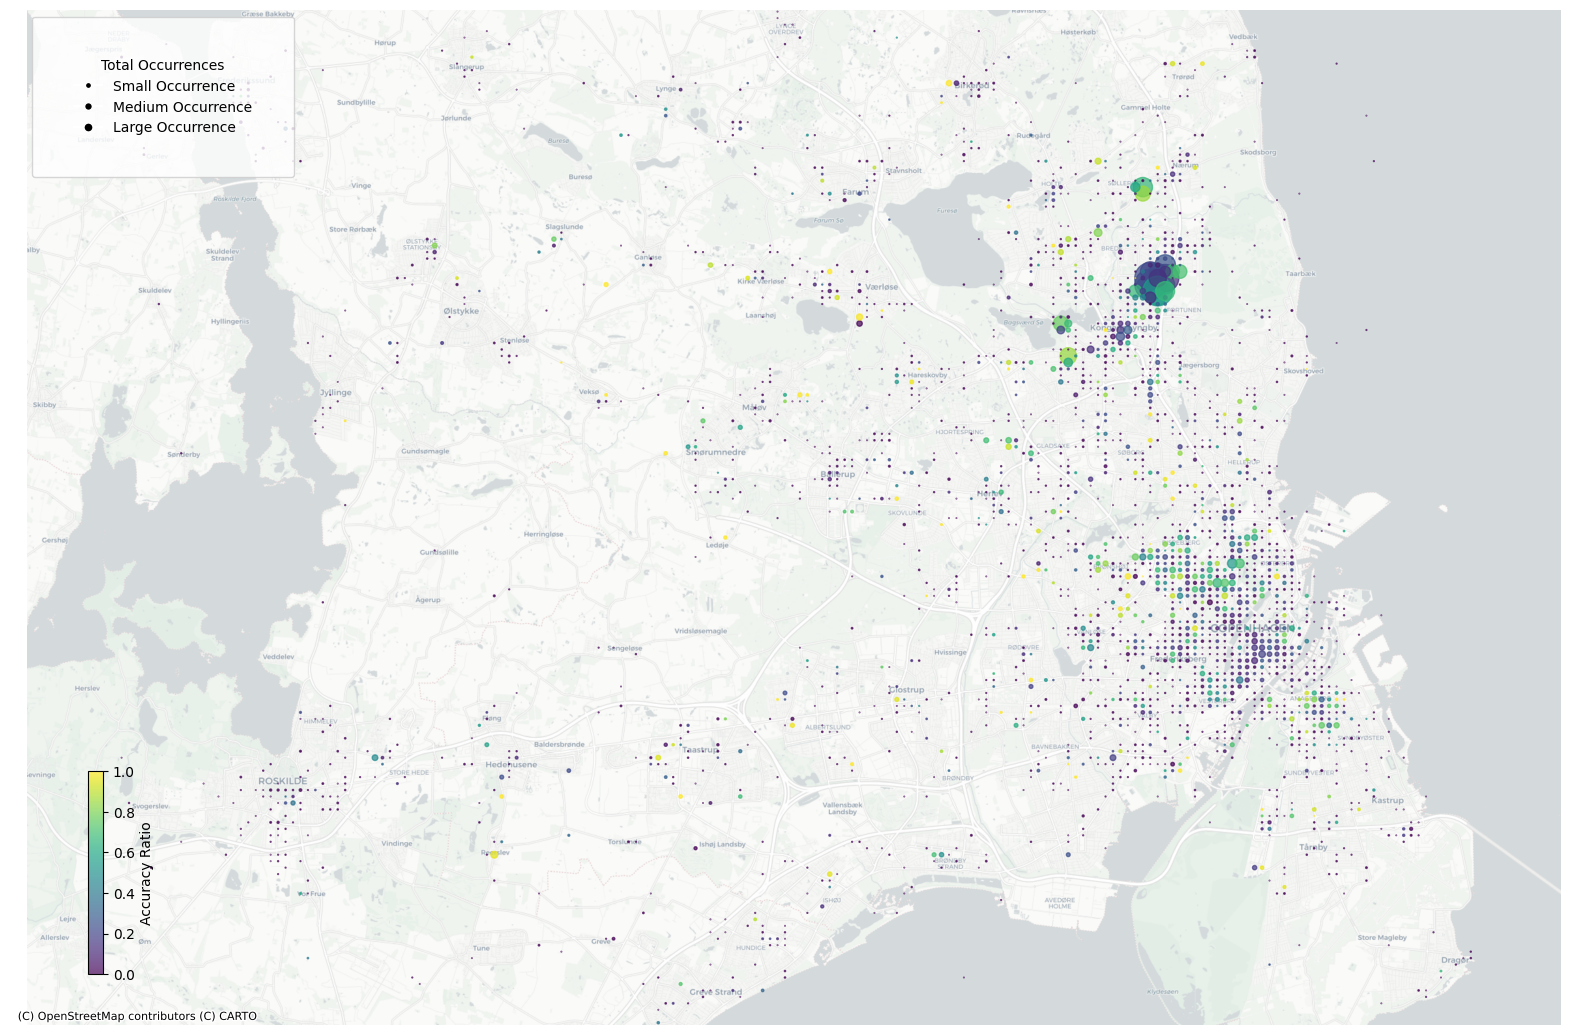

In [17]:
# Plotting
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(labels_df, geometry=gpd.points_from_xy(labels_df.lon, labels_df.lat))

# Set the coordinate reference system to WGS84
gdf.crs = "EPSG:4326"

# Convert to Web Mercator (this CRS is used by most web maps)
gdf = gdf.to_crs(epsg=3857)

# Apply a logarithmic transformation to scale total_occurrences
# Adding 1 to avoid taking log of zero
gdf['log_scaled_total_occurrences'] = (gdf['total_occurrences'])*0.2  # Adjust the multiplier as needed


fig, ax = plt.subplots(figsize=(20, 15))  # Increase the figure size

# Create a scatter plot for coloring by accuracy_ratio and sizing by log_scaled_total_occurrences
scatter = ax.scatter(gdf.geometry.x, gdf.geometry.y, 
                     s=gdf['log_scaled_total_occurrences'],  # Size by log-scaled total_occurrences
                     c=gdf['accuracy_ratio'],  # Color by accuracy_ratio
                     cmap='viridis', alpha=0.7 )

# Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=12)


# Adjust map limits
buffer = 5000
xmin, ymin, xmax, ymax = gdf.total_bounds
ax.set_xlim(xmin - buffer, xmax + buffer)
ax.set_ylim(ymin + 2*buffer, ymax - buffer)

# Remove axis
ax.set_axis_off()

axins = inset_axes(ax,
                   width="1%",  # width of the colorbar
                   height="20%",  # height of the colorbar
                   loc='lower left',
                   bbox_to_anchor=(0.05, 0.05, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

# Add the colorbar to the inset
cbar = fig.colorbar(scatter, cax=axins)
cbar.set_label('Accuracy Ratio')


# Create custom legend for marker sizes (total_occurrences)
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Small Occurrence',
                          markerfacecolor='k', markersize=np.sqrt(np.log1p(50)*5)),
                   Line2D([0], [0], marker='o', color='w', label='Medium Occurrence',
                          markerfacecolor='k', markersize=np.sqrt(np.log1p(500)*5)),
                   Line2D([0], [0], marker='o', color='w', label='Large Occurrence',
                          markerfacecolor='k', markersize=np.sqrt(np.log1p(5000)*5))]
ax.legend(handles=legend_elements, loc='upper left', title="Total Occurrences",  bbox_to_anchor=(0.01, 0, 2, 1),
                          bbox_transform=ax.transAxes,
                          borderpad=3)

# Save and show plot
plt.savefig("../../figures/maps/prediction_accuracy_map.png", dpi=300)  # Save the map as a PNG file with high DPI
plt.show()


In [18]:
pos_counts

,pos,no_unique_users
0,"(1, 39)",1
1,"(1, 51)",2
2,"(1, 55)",1
3,"(1, 56)",1
4,"(1, 58)",2
...,...,...
6256,"(199, 143)",2
6257,"(199, 148)",5
6258,"(199, 149)",5
6259,"(199, 150)",2


In [19]:
def tensor_to_list(tensor):
    list_of_lists = []
    for row in tensor:
        # Convert to list and remove zeros
        list_without_padding = [x.item() for x in row if x not in (0, 1, 2, 3)]
        list_of_lists.append(list_without_padding)
    return list_of_lists

In [20]:
y_modified = [] 
for pred_list, exp_list, mask_list in zip(y_predicted, y_expected, random_mask):
    modified_list = []
    for pred, exp, mask in zip(pred_list, exp_list, mask_list):
        modified_list.append(pred if mask else exp)
    y_modified.append(modified_list)

In [21]:
# Convert the tensor and remove padding
expected_trajecory = tensor_to_list(y_expected)
predicted_trajecory = tensor_to_list(y_modified)

In [22]:
import folium
import numpy as np

def plot_trajectory(binned_coords, lat_bins, lon_bins):
    # Convert string coordinates to tuples
    coord_tuples = [eval(coord) for coord in binned_coords]

    # Convert bin numbers to center points of the bins
    center_points = []
    for lat_bin, lon_bin in coord_tuples:
        lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
        lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
        center_points.append((lat_center, lon_center))

    # Create Folium map centered on the first point
    m = folium.Map(location=center_points[0], zoom_start=12)

    # Add points to the map
    folium.PolyLine(center_points, color="blue", weight=2.5, opacity=1).add_to(m)

    return m

In [23]:
import folium
import numpy as np

def plot_multiple_trajectories(list_of_trajectories, lat_bins, lon_bins):
    # Predefined colors for different trajectories
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'darkblue', 'lightgreen', 'gray', 'darkred', 'lightblue']

    # Initialize map; center on the first point of the first trajectory
    if list_of_trajectories:
        first_coord = eval(list_of_trajectories[0][0])
        lat_center = (lat_bins[first_coord[0] - 1] + lat_bins[first_coord[0]]) / 2
        lon_center = (lon_bins[first_coord[1] - 1] + lon_bins[first_coord[1]]) / 2
        m = folium.Map(location=(lat_center, lon_center), zoom_start=12)
    else:
        return "No trajectories provided"

    # Process and plot each trajectory
    for idx, trajectory in enumerate(list_of_trajectories):
        color = colors[idx % len(colors)]  # Cycle through colors

        # Convert string coordinates to tuples and then to center points
        coord_tuples = [eval(coord) for coord in trajectory]
        center_points = []
        for lat_bin, lon_bin in coord_tuples:
            lat_center = (lat_bins[lat_bin - 1] + lat_bins[lat_bin]) / 2
            lon_center = (lon_bins[lon_bin - 1] + lon_bins[lon_bin]) / 2
            center_points.append((lat_center, lon_center))

        # Add trajectory to the map
        folium.PolyLine(center_points, color=color, weight=2.5, opacity=1).add_to(m)

    return m

In [24]:
expected_trajecory == predicted_trajecory

False

In [25]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in [x[1:] for x in expected_trajecory]], lat_bins, lon_bins)

In [26]:
plot_multiple_trajectories([[vocab[i] for i in l] for l in [x[1:] for x in predicted_trajecory]], lat_bins, lon_bins)